# Weather prediction based on historical data
==================================================================================================================

# Data: OPSD - Weather data


https://doi.org/10.25832/weather_data/2020-09-16

by Open Power System Data: http://www.open-power-system-data.org/

Package Version: 2020-09-16

License: "Open Power System Data. 2020. Data Package Weather Data. Version
          2020-09-16. https://doi.org/10.25832/weather_data/2020-09-16. (Primary
          data from various sources, for a complete list see URL)."

# Goal
The OPSD-Weather dataset provides historical weather data from 1980 to 2019 for various countries in europe.
For each country the outside temperature (°C), direct and diffuse radiation (W/m^2) is available.

The goal here is to pick up data for some country, explore it a bit and create a prediction model, to see how well we can predict the weather. The number of features or the model architechture can be explored further.

In [108]:
#Libs
import pandas as pd
import numpy as np
from datetime import datetime
from IPython.display import display
import matplotlib as mpt
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Data Import

In [4]:
#import the data
filename_weather = "opsd-weather_data-2020-09-16\\weather_data.csv"

df_weather = pd.read_csv(filename_weather)

#A quick peek
display(df_weather)
display(df_weather.describe().T)
display(df_weather.info())

,utc_timestamp,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
0,1980-01-01T00:00:00Z,-3.640,0.0,0.0,-0.720,0.0,0.0,4.664,0.0,0.0,...,0.0,-3.945,0.0,0.0,-3.055,0.0,0.0,-4.648,0.0,0.0
1,1980-01-01T01:00:00Z,-3.803,0.0,0.0,-1.165,0.0,0.0,4.052,0.0,0.0,...,0.0,-4.053,0.0,0.0,-3.272,0.0,0.0,-4.554,0.0,0.0
2,1980-01-01T02:00:00Z,-3.969,0.0,0.0,-1.434,0.0,0.0,3.581,0.0,0.0,...,0.0,-4.129,0.0,0.0,-3.639,0.0,0.0,-4.455,0.0,0.0
3,1980-01-01T03:00:00Z,-4.076,0.0,0.0,-1.843,0.0,0.0,3.197,0.0,0.0,...,0.0,-4.139,0.0,0.0,-4.202,0.0,0.0,-4.421,0.0,0.0
4,1980-01-01T04:00:00Z,-4.248,0.0,0.0,-2.094,0.0,0.0,2.750,0.0,0.0,...,0.0,-4.239,0.0,0.0,-4.732,0.0,0.0,-4.449,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350635,2019-12-31T19:00:00Z,-1.386,0.0,0.0,1.684,0.0,0.0,-1.351,0.0,0.0,...,0.0,-0.382,0.0,0.0,0.053,0.0,0.0,-0.766,0.0,0.0
350636,2019-12-31T20:00:00Z,-1.661,0.0,0.0,1.718,0.0,0.0,-1.009,0.0,0.0,...,0.0,-0.418,0.0,0.0,-0.207,0.0,0.0,-0.742,0.0,0.0
350637,2019-12-31T21:00:00Z,-1.986,0.0,0.0,1.726,0.0,0.0,-0.986,0.0,0.0,...,0.0,-0.490,0.0,0.0,-0.203,0.0,0.0,-0.764,0.0,0.0
350638,2019-12-31T22:00:00Z,-2.184,0.0,0.0,1.569,0.0,0.0,-1.270,0.0,0.0,...,0.0,-0.434,0.0,0.0,-0.032,0.0,0.0,-0.867,0.0,0.0


,count,mean,std,min,25%,50%,75%,max
AT_temperature,350640.0,7.778066,9.067683,-25.301,0.582,7.67300,14.744000,33.7450
AT_radiation_direct_horizontal,350640.0,93.706084,175.561727,0.000,0.000,0.46855,98.262000,890.0541
AT_radiation_diffuse_horizontal,350640.0,66.977420,90.385764,0.000,0.000,7.15960,115.359875,415.7541
BE_temperature,350640.0,9.783023,7.172334,-17.119,4.474,9.63200,14.983000,37.9180
BE_radiation_direct_horizontal,350640.0,81.329036,165.637688,0.000,0.000,0.20300,60.971500,854.1106
...,...,...,...,...,...,...,...,...
SI_radiation_direct_horizontal,350640.0,102.882347,191.086460,0.000,0.000,0.37360,109.257500,912.3095
SI_radiation_diffuse_horizontal,350640.0,62.914420,86.273344,0.000,0.000,6.47125,104.179650,417.6111
SK_temperature,350640.0,8.085738,9.769178,-27.075,0.292,8.16400,15.668000,35.8270
SK_radiation_direct_horizontal,350640.0,93.237304,177.362890,0.000,0.000,0.35950,91.122775,885.4145


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350640 entries, 0 to 350639
Data columns (total 85 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   utc_timestamp                    350640 non-null  object 
 1   AT_temperature                   350640 non-null  float64
 2   AT_radiation_direct_horizontal   350640 non-null  float64
 3   AT_radiation_diffuse_horizontal  350640 non-null  float64
 4   BE_temperature                   350640 non-null  float64
 5   BE_radiation_direct_horizontal   350640 non-null  float64
 6   BE_radiation_diffuse_horizontal  350640 non-null  float64
 7   BG_temperature                   350640 non-null  float64
 8   BG_radiation_direct_horizontal   350640 non-null  float64
 9   BG_radiation_diffuse_horizontal  350640 non-null  float64
 10  CH_temperature                   350640 non-null  float64
 11  CH_radiation_direct_horizontal   350640 non-null  float64
 12  CH

None

In [22]:
# Copy data for Germany into a separate df which can be used for this exercise.
df_de = df_weather[["utc_timestamp",
            "DE_temperature",
            "DE_radiation_direct_horizontal",
            "DE_radiation_diffuse_horizontal"]].copy()

display(df_de.head())

,utc_timestamp,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal
0,1980-01-01T00:00:00Z,-1.261,0.0,0.0
1,1980-01-01T01:00:00Z,-1.414,0.0,0.0
2,1980-01-01T02:00:00Z,-1.571,0.0,0.0
3,1980-01-01T03:00:00Z,-1.760,0.0,0.0
4,1980-01-01T04:00:00Z,-1.995,0.0,0.0


In [23]:
df_de.describe()

,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal
count,350640.000000,350640.000000,350640.000000
mean,8.785579,77.780040,69.077824
std,8.154343,153.118508,91.873616
min,-19.807000,0.000000,0.000000
25%,2.452000,0.000000,0.000000
50%,8.568000,0.369850,6.323600
75%,14.919000,70.400900,123.667325
max,35.479000,849.984900,397.829300


In [24]:
df_de.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350640 entries, 0 to 350639
Data columns (total 4 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   utc_timestamp                    350640 non-null  object 
 1   DE_temperature                   350640 non-null  float64
 2   DE_radiation_direct_horizontal   350640 non-null  float64
 3   DE_radiation_diffuse_horizontal  350640 non-null  float64
dtypes: float64(3), object(1)
memory usage: 10.7+ MB


The data has been imported in the correct format except for the timestamp, which can be corrected. That can be used as the index as well

In [25]:
df_de["utc_timestamp"] = pd.to_datetime(df_de["utc_timestamp"])
df_de.set_index(df_de["utc_timestamp"], inplace=True)
df_de.drop(["utc_timestamp"], axis=1, inplace=True)
#Rename the columns with some easily accessible names
df_de.columns = ["Temp","Rad_direct", "Rad_diffuse" ]
df_de.index.name = "timestamp"
df_de.head()

,Temp,Rad_direct,Rad_diffuse
timestamp,,,
1980-01-01 00:00:00+00:00,-1.261,0.0,0.0
1980-01-01 01:00:00+00:00,-1.414,0.0,0.0
1980-01-01 02:00:00+00:00,-1.571,0.0,0.0
1980-01-01 03:00:00+00:00,-1.760,0.0,0.0
1980-01-01 04:00:00+00:00,-1.995,0.0,0.0


# Visualization

Text(0.5, 1.0, 'Radiation Diffuse (W/m^2)')

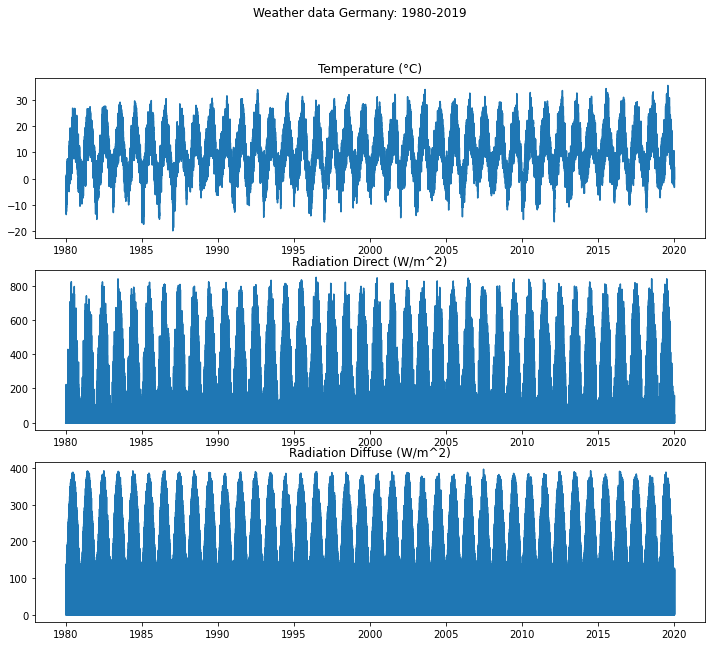

In [31]:
#Plot the entire data to see general profile
fig, axs = plt.subplots(3, figsize=(12, 10))
fig.suptitle('Weather data Germany: 1980-2019')
axs[0].plot(df_de.Temp)
axs[0].set_title("Temperature (°C)")
axs[1].plot(df_de.Rad_direct)
axs[1].set_title("Radiation Direct (W/m^2)")
axs[2].plot(df_de.Rad_diffuse)
axs[2].set_title("Radiation Diffuse (W/m^2)")

Text(0.5, 1.0, 'Radiation Diffuse (W/m^2)')

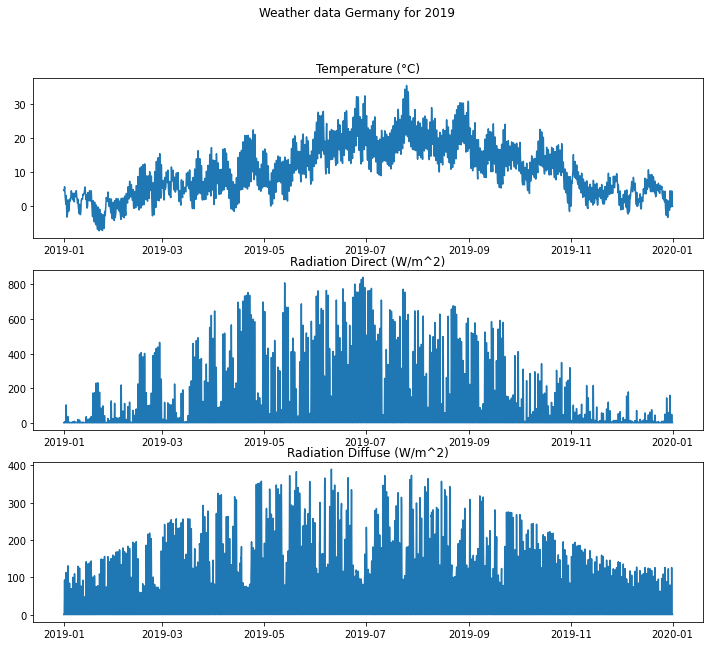

In [32]:
#Plot the data for just 2019 to see general profile
fig, axs = plt.subplots(3, figsize=(12, 10))
fig.suptitle('Weather data Germany for 2019')
axs[0].plot(df_de.Temp["2019"])
axs[0].set_title("Temperature (°C)")
axs[1].plot(df_de.Rad_direct["2019"])
axs[1].set_title("Radiation Direct (W/m^2)")
axs[2].plot(df_de.Rad_diffuse["2019"])
axs[2].set_title("Radiation Diffuse (W/m^2)")

This is weather data and there is obviously trend and seasonality. But just to visualize them using the library functions.

0.9945572621233718


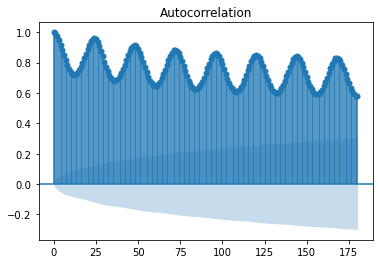

In [83]:
print(df_de['Temp'].autocorr())
plot_acf(df_de['Temp']["2019"], lags=180)
plt.show()

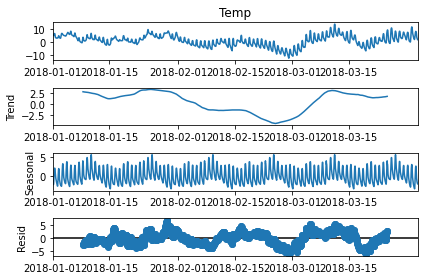

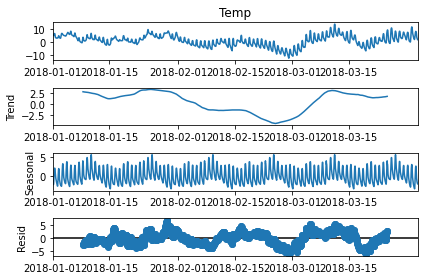

In [84]:
#using the seasonal_decompose
result = seasonal_decompose(df_de['Temp']["2018-01":"2018-03"], model='additive', period=360)
result.plot()

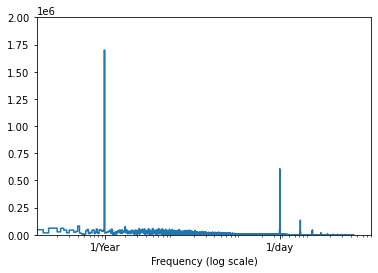

In [249]:
fft = tf.signal.rfft(df_de['Temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_de['Temp'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 2000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


In [251]:
years_per_dataset

39.99973716805146

# Dataset preparation



In [193]:
#CLASS TO PREPARE DATA
class PrepareData():
    def __init__(self, data, split_list, window_size, label_size, batch_size):
        self.data=data
        self.datalength=data.shape[0]
        self.num_timesteps=data.shape[0]
        self.num_features=data.shape[1]
        
        self.split_list=split_list
        self.window_size=window_size
        self.label_size=label_size
        self.batch_size=batch_size
        #print([int(self.datalength*x) for x in np.cumsum(self.split_list[:-1])])
        splits=np.split(data,[int(self.num_timesteps*x) for x in np.cumsum(self.split_list[:-1])])
        
        self.train_data=splits[0]
        self.val_data=splits[1]
        self.test_data=splits[2]
        
        #self.train_data = data[:int(split_list[0]*self.num_timesteps),:]
        #self.val_data = data[int(split_list[0]*self.num_timesteps):int(sum(split_list[0:2])*self.num_timesteps),:]
        #self.test_data = data[int(sum(split_list[0:2])*self.num_timesteps):,:]
        
    def __repr__(self):
        return '\n'.join([
            f'Training data: {self.train_data.shape}',
            f'Validation data: {self.val_data.shape}',
            f'Testing data: {self.test_data.shape}',
        ])

    def make_dataset(self, data_in, shuffle_buffer=None):
        tfdf=tf.data.Dataset.from_tensor_slices(data_in)
        tfdf=tfdf.window(self.window_size+self.label_size,shift=1,drop_remainder=True)
        tfdf=tfdf.flat_map(lambda window:window.batch(self.window_size+self.label_size))
        if shuffle_buffer:
            tfdf=tfdf.shuffle(shuffle_buffer)
        tfdf=tfdf.map(lambda window: (window[:-self.label_size],window[-self.label_size:]))
        tfdf=tfdf.batch(self.batch_size).prefetch(2)
        return tfdf
    
    @property
    def get_targets(self):
        print("in")
        targets=np.array([])
        print("in")
        for features, labels in self.test_dataset:#dataset.test_dataset:
            targets = np.append(targets,labels.numpy())
        targets=targets.reshape((int(len(targets)/self.num_features),self.num_features))
        return targets
    
    
    def get_targets_sc(self, tfdf):
        targets=np.array([])
        for features, labels in tfdf.test_dataset:
            targets = np.append(targets,labels.numpy())
        targets=targets.reshape((int(len(targets)/self.num_features),self.num_features))
        return targets
        
    @property
    def train_dataset(self):
        return self.make_dataset(self.train_data, len(self.train_data))
    
    @property
    def val_dataset(self):
        return self.make_dataset(self.val_data, len(self.val_data))
    
    @property
    def test_dataset(self):
        return self.make_dataset(self.test_data)

In [177]:
#configuration
split_list=[0.7,0.2,0.1]
window_size=12
label_size=1
batch_size=10

data = df_de["2015":"2019"]

num_features = data.shape[1]

dataset = PrepareData(data,split_list,window_size,label_size,batch_size)
dataset

Training data: (30676, 3)
Validation data: (8765, 3)
Testing data: (4383, 3)

In [178]:
#prepare a scaled dataset
scaler=MinMaxScaler(feature_range=(0,1))
data_scaled=scaler.fit_transform(data)

datasetsc=PrepareData(data_scaled,split_list,window_size,label_size,batch_size)
datasetsc

Training data: (30676, 3)
Validation data: (8765, 3)
Testing data: (4383, 3)

# Model

In [179]:
#MODEL
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,input_shape=[window_size, num_features]),
    tf.keras.layers.Dense(3)
])

optimizer = tf.keras.optimizers.RMSprop()
loss='mse'

model.compile(loss=loss,optimizer=optimizer,metrics=['mae'])

history=model.fit(datasetsc.train_dataset,epochs=10,validation_data=datasetsc.val_dataset)

Epoch 1/10
3067/3067 [==============================] - 7s 2ms/step - loss: 0.0348 - mae: 0.1378 - val_loss: 0.0309 - val_mae: 0.1335
Epoch 2/10
3067/3067 [==============================] - 7s 2ms/step - loss: 0.0305 - mae: 0.1272 - val_loss: 0.0307 - val_mae: 0.1321
Epoch 3/10
3067/3067 [==============================] - 7s 2ms/step - loss: 0.0305 - mae: 0.1276 - val_loss: 0.0308 - val_mae: 0.1255
Epoch 4/10
3067/3067 [==============================] - 8s 2ms/step - loss: 0.0303 - mae: 0.1267 - val_loss: 0.0306 - val_mae: 0.1306
Epoch 5/10
3067/3067 [==============================] - 7s 2ms/step - loss: 0.0304 - mae: 0.1269 - val_loss: 0.0306 - val_mae: 0.1301
Epoch 6/10
3067/3067 [==============================] - 8s 2ms/step - loss: 0.0306 - mae: 0.1277 - val_loss: 0.0308 - val_mae: 0.1290
Epoch 7/10
3067/3067 [==============================] - 7s 2ms/step - loss: 0.0305 - mae: 0.1273 - val_loss: 0.0310 - val_mae: 0.1344
Epoch 8/10
3067/3067 [==============================] - 7s 2ms

In [180]:
#PREDICT
forecasts = model.predict(datasetsc.test_dataset)

#forecasts=forecasts.ravel()

#dd=np.array([])
#for i,l in datasetsc.test_dataset:
#    dd=np.append(dd,l.numpy().ravel())
    
#plot scaled data
#plt.plot(datasetsc.get_targets_sc(datasetsc))
#plt.plot(forecasts)

In [187]:
forecasts.ravel().shape

(157356,)

In [194]:
targets = datasetsc.get_targets
targets

<bound method PrepareData.get_targets of Training data: (30676, 3)
Validation data: (8765, 3)
Testing data: (4383, 3)>

In [195]:
targets = dataset.get_targets
targets.shape

AttributeError: 'function' object has no attribute 'shape'

In [215]:
#Using pandas shift

def prep_seq(data_in, in_steps=1, out_steps=1):
    df = pd.DataFrame(data_in)
    dff=df.copy()
    for i in range(1,in_steps+out_steps):
        shifted=df.shift(-i)
        dff=pd.concat([dff,shifted],axis=1).dropna()
    inputs, labels=dff.iloc[:,:-1].values, dff.iloc[:,-1].values.reshape(-1,1)
    return inputs, labels

#assumes last colum to be the label column (only one label in this casea)
def prep_Seq(data_in, in_steps, out_steps):
    df_in=data_in.iloc[:,:-1].copy()
    df_out=data_in.iloc[:,-1].copy()
    for i in range(1,in_steps+out_steps):
        shifted=df_in.shift(-i)
        df_in=pd.concat([df_in,shifted],axis=1).dropna()
        shifted=df_out.shift(-i)
        df_out=pd.concat([df_out,shifted],axis=1).dropna()
    inputs, labels=df_in.values, df_out.iloc[:,-1].values.reshape(-1,1)
    return inputs, labels

In [254]:
n_features=3
n_inputs = 3
n_labels=1

data = df_de["2014":"2018"]

scaler=MinMaxScaler(feature_range=(0,1))
data_scaled=scaler.fit_transform(data)

data_scaled = pd.DataFrame(data_scaled)

X,y=prep_seq(data_scaled,n_inputs,n_labels)

print(X,y)
print(X.shape,y.shape)

ValueError: Expected 2D array, got 1D array instead:
array=[-0.568 -0.509 -0.436 ...  4.992  4.905  4.843].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [253]:
data

timestamp
2014-01-01 00:00:00+00:00   -0.568
2014-01-01 01:00:00+00:00   -0.509
2014-01-01 02:00:00+00:00   -0.436
2014-01-01 03:00:00+00:00   -0.257
2014-01-01 04:00:00+00:00   -0.082
                             ...  
2018-12-31 19:00:00+00:00    4.963
2018-12-31 20:00:00+00:00    5.005
2018-12-31 21:00:00+00:00    4.992
2018-12-31 22:00:00+00:00    4.905
2018-12-31 23:00:00+00:00    4.843
Name: Temp, Length: 43824, dtype: float64

In [228]:
data_test = df_de["2019"]

scaler=MinMaxScaler(feature_range=(0,1))
data_test_scaled=scaler.fit_transform(data_test)

data_test_scaled = pd.DataFrame(data_test_scaled)


Xt,yt=prep_Seq(data_test_scaled,n_inputs,n_labels)
print(Xt,yt)
print(Xt.shape,yt.shape)

[[2.81727730e-01 0.00000000e+00 2.80791291e-01 ... 0.00000000e+00
  2.74704436e-01 0.00000000e+00]
 [2.80791291e-01 0.00000000e+00 2.79995318e-01 ... 0.00000000e+00
  2.75102423e-01 5.55132701e-05]
 [2.79995318e-01 0.00000000e+00 2.78450193e-01 ... 5.55132701e-05
  2.79035468e-01 4.76320500e-04]
 ...
 [2.10066721e-01 1.85915962e-04 2.02294276e-01 ... 0.00000000e+00
  1.80545476e-01 0.00000000e+00]
 [2.02294276e-01 0.00000000e+00 1.96745874e-01 ... 0.00000000e+00
  1.74692731e-01 0.00000000e+00]
 [1.96745874e-01 0.00000000e+00 1.91267705e-01 ... 0.00000000e+00
  1.68371766e-01 0.00000000e+00]] [[0.        ]
 [0.00804007]
 [0.05538387]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]
(8754, 16) (8754, 1)


Epoch 1/20
1370/1370 [==============================] - 9s 5ms/step - loss: 0.0328
Epoch 2/20
1370/1370 [==============================] - 7s 5ms/step - loss: 0.0135
Epoch 3/20
1370/1370 [==============================] - 7s 5ms/step - loss: 0.0098
Epoch 4/20
1370/1370 [==============================] - 7s 5ms/step - loss: 0.0075
Epoch 5/20
1370/1370 [==============================] - 7s 5ms/step - loss: 0.0062
Epoch 6/20
1370/1370 [==============================] - 7s 5ms/step - loss: 0.0059
Epoch 7/20
1370/1370 [==============================] - 7s 5ms/step - loss: 0.0055
Epoch 8/20
1370/1370 [==============================] - 7s 5ms/step - loss: 0.0053
Epoch 9/20
1370/1370 [==============================] - 7s 5ms/step - loss: 0.0052
Epoch 10/20
1370/1370 [==============================] - 8s 6ms/step - loss: 0.0051
Epoch 11/20
1370/1370 [==============================] - 8s 6ms/step - loss: 0.0050
Epoch 12/20
1370/1370 [==============================] - 8s 6ms/step - loss: 0.0048
E

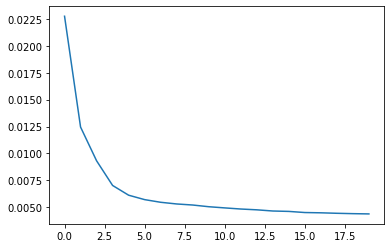

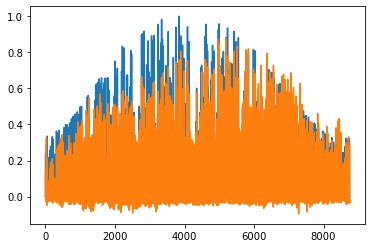

In [231]:
#model for pandas made input
model_lstm_m=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1)),
    tf.keras.layers.LSTM(16,activation='relu',input_shape=(1,4)),
    tf.keras.layers.Dense(1)
])
model_lstm_m.compile(loss='mse',optimizer='adam')
history_lstm_m=model_lstm_m.fit(x=X,y=y,epochs=20)
yhat_lstm_m=model_lstm_m.predict(Xt)
plt.figure(0)
plt.plot(history_lstm_m.history['loss'])
print(yt,yhat_lstm_m)
plt.figure(1)
plt.plot(yt)
plt.plot(yhat_lstm_m)

Epoch 1/50
1370/1370 [==============================] - 2s 789us/step - loss: 0.1266
Epoch 2/50
1370/1370 [==============================] - 1s 744us/step - loss: 0.1055
Epoch 3/50
1370/1370 [==============================] - 1s 871us/step - loss: 0.0997
Epoch 4/50
1370/1370 [==============================] - 1s 757us/step - loss: 0.0969
Epoch 5/50
1370/1370 [==============================] - 1s 780us/step - loss: 0.0969
Epoch 6/50
1370/1370 [==============================] - 1s 880us/step - loss: 0.0969
Epoch 7/50
1370/1370 [==============================] - 1s 760us/step - loss: 0.0953
Epoch 8/50
1370/1370 [==============================] - 1s 805us/step - loss: 0.0950
Epoch 9/50
1370/1370 [==============================] - 1s 917us/step - loss: 0.0948
Epoch 10/50
1370/1370 [==============================] - 1s 813us/step - loss: 0.0946
Epoch 11/50
1370/1370 [==============================] - 1s 995us/step - loss: 0.0959
Epoch 12/50
1370/1370 [==============================] - 1s 758

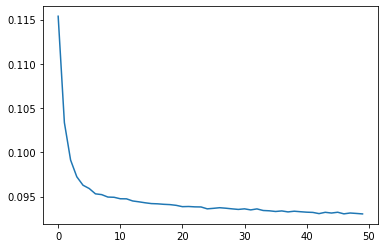

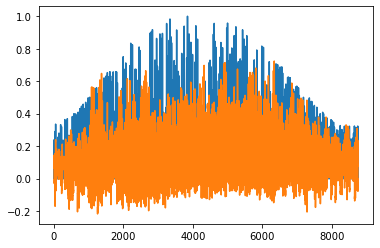

In [230]:
model_lr = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[16]),
    tf.keras.layers.Dense(1)
])
model_lr.compile(optimizer='RMSprop', loss='mae')
history_lr=model_lr.fit(x=X,y=y,epochs=50)
yhat_lr=model_lr.predict(Xt)
print(yt,yhat_lr)
plt.figure(0)
plt.plot(history_lr.history["loss"],label='loss')
print(model_lr.summary())
plt.figure(1)
plt.plot(yt,label='target')
plt.plot(yhat_lr,label='prediction')


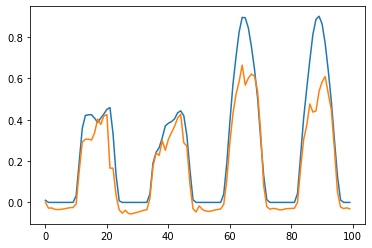

In [236]:
t = slice(2700,2800,1)

plt.plot(yt[t])
plt.plot(yhat_lstm_m[t])